# Optimal Extraction Algorithm
## Introduction

Optimal extraction is an advance method to extract a _1D_ spectrum from a _2D_ spectrum image (See [Horne, Keith. 1986](http://adsabs.harvard.edu/abs/1986PASP...98..609H)). Normally you would just sum up a number of lines along the spatial direction for the whole dispersion direction to obtain a _1D_ spectrum in counts, but there are the _Cosmic Rays_. Cosmic Rays create a very distinctive feature in the image and it will look very similar to a hot pixel, they have to be masked out.

## Mathematics
The [paper](http://adsabs.harvard.edu/abs/1986PASP...98..609H) describes a set of equations defining each process, I will reproduce them here for reference.

|  Process | Equation lsdlakdlaksdlasldkalskdlaksldkalsdkasd|
|:--------------------------|----------------------------------------|
| 1. Initial Image Processing  | $$D=\frac{(C-B)}{F}$$ |
| 2. Initial Variance Estimate | $$V=V_0+\frac{\left|D\right|}{Q}$$  |
| 3. Fit Sky Background  | $$S=FIT_x\left[ D;V\right]$$  |
| 4. Extract Standard Spectrum  | $$f=\sum_x (D - S)$$  |
| 5. Variance of Standard Spectrum  | $$var\left[f\right]= \sum_xV$$  |
| 6. Construct Spatial Profile  | $$P=FIT_\lambda\left[\left(D-S\right)/f;V/f^2\right]$$  |
| 7. Enforce Positivity  | $$P = MAX\left[P;0\right]$$   |
| 8. Enforce Normalization  | $$P=P/\sum_xP$$  |
| 9. Revise Variance Estimates | $$V = V_0 + \left|fP+S\right|/Q$$ |
| 10. Mask Cosmic Ray Hit | $$M=\begin{cases} 0 & \text{if $\left(D-S-fP\right)^2 > \sigma_{clip}^2V$ }\\ 1 & \text{otherwise}\end{cases}$$ |
| 11. Extract Optimal Extraction | $$f = \frac{\sum_xMP\left(D-S\right)/V}{\sum_xMP^2/V}$$ |
| 12. Variance of Optimal Spectrum | $$var\left|f\right| = \frac{\sum_xMP}{\sum_xMP^2/V}$$ |
| 13. Iterate Steps 6 Through 12 | |


## Find the best fitting model

First we load some packages

In [32]:
from ccdproc import CCDData
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import numpy as np


Now we load a sample image. Displayed below.

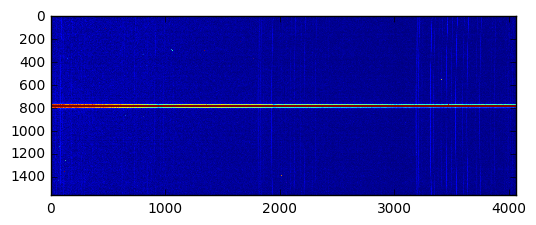

In [33]:

sample_file  = '/data/simon/data/soar/work/20161114_eng_3/RED4/cfzsto_0216_EG21_1200M5_GG455.fits' #cfzsto_0199_EG21_400M2_GG455.fits'
ccd = CCDData.read(sample_file)

plt.imshow(ccd.data, clim=(0, 350))
plt.show()

Cutting the image at a _random_ location we can see the profile. This profile is affected by the instrument and the seeing.

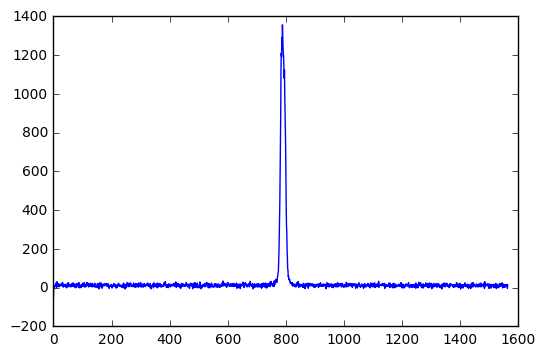

In [34]:
plt.plot(ccd.data[:,500])
plt.show()

Let's define a function that will do a fit and plot both the data and the model as well as the residues.

In [35]:
voigt_model = models.Voigt1D(x_0=100, amplitude_L=500, fwhm_L=8, fwhm_G=8).rename('Voigt')
gauss_model = models.Gaussian1D(amplitude=500, mean=100, stddev=8).rename('Gaussian')
lorentz_model = models.Lorentz1D(x_0=100, amplitude=500, fwhm=8).rename('Lorentz')
all_model = [voigt_model, gauss_model, lorentz_model]
fitter = fitting.LevMarLSQFitter()

def fit_profile(column, all_model, fitter):
    sample_data = np.median(ccd.data[:,column:column+10], axis=1)
    x_axis = range(len(sample_data))
    max_value = np.max(sample_data)
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
    ax1.plot(x_axis, sample_data, color='k', label='Data')
    ax2.set_xlabel('Pixel (Spatial Direction)')
    ax1.set_ylabel('Intensity (ADU)')
    ax2.set_ylabel('RMSE')
    colors = ['r','g','c']
    all_fitted_models = []
    for model in all_model:
        # center
        try:
            model.x_0.value = column
        
        except AttributeError:
            model.mean.value = column
        # Amplitude   
        try:
            model.amplitude_L = max_value
        except AttributeError:
            model.amplitude = max_value
        # The actual fitting
        fitted_profile = fitter(model, x_axis, sample_data)
        all_fitted_models.append(fitted_profile)
        difference = np.sqrt((sample_data - fitted_profile(x_axis)) ** 2)
        color = colors.pop()
        ax1.plot(x_axis, fitted_profile(x_axis), color=color, label=model.name)
        ax1.legend(loc='best')
        ax1.set_xlim((column - 150, column + 150))
        ax2.plot(x_axis, difference, color=color, label='RMS {:s}'.format(model.name))
        ax2.set_ylim(ax1.get_ylim())
        ax2.legend(loc='best')
    plt.show()
    return x_axis, all_fitted_models
    

Now we can call it for all the profiles.

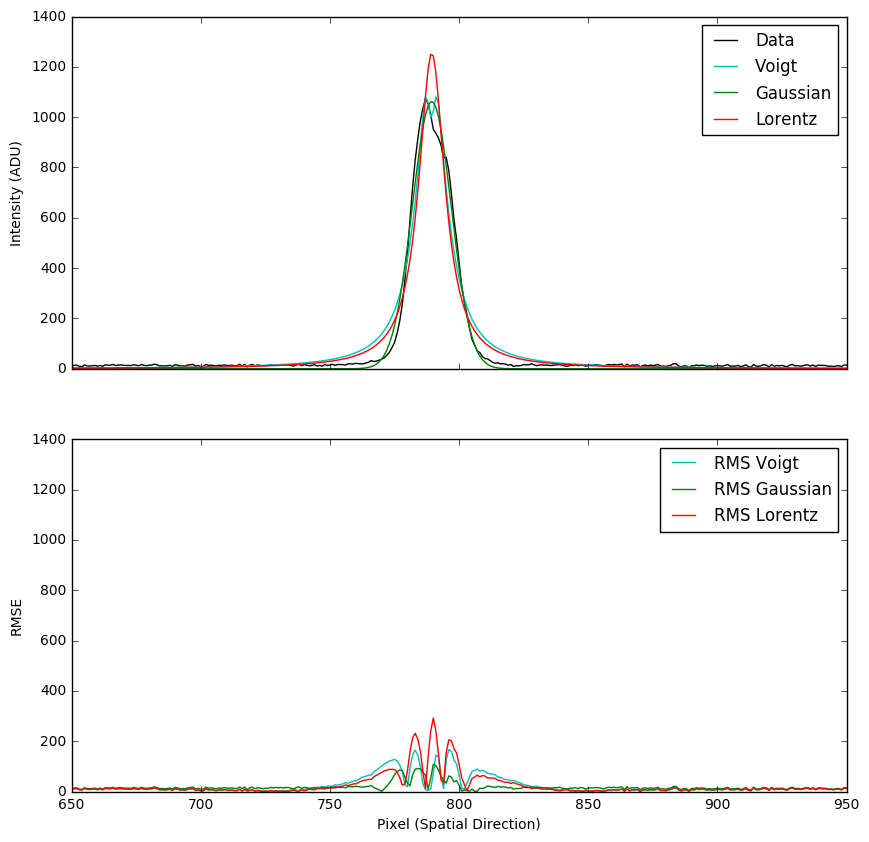

In [36]:
x_axis, all_fitted_models = fit_profile(column=800, all_model=all_model, fitter=fitter)

## Initial Variance Estimate
$$V_{x\lambda} = V_0 + \left|D_{x\lambda}\right|/Q$$

_Where $\sqrt{V_0}$ is the root-mean-squared readout noise in data numbers and $Q$ is the effective number of photons per data number_

So it seems clear that the best fit is a gaussian.

## Finding Weights

First we recover the _Gaussian_ fitted model 
                                 

Model: Gaussian1D
Name: Gaussian
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    1062.68821593 789.408814477 7.54599454246


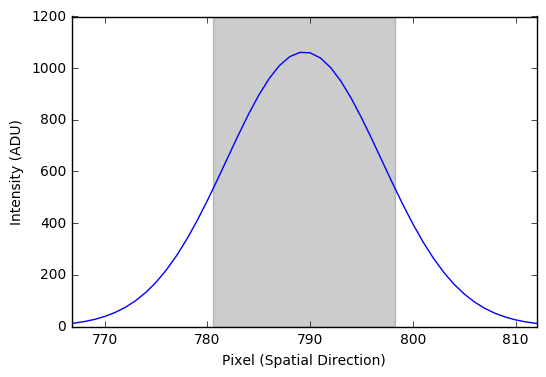

In [37]:
# x_axis = 
gaussian = (model for model in all_fitted_models if model.name == 'Gaussian').next()
print(gaussian)
fwhm = 2.355 * gaussian.stddev.value
xmin = gaussian.mean.value - 3 * gaussian.stddev.value
xmax = gaussian.mean.value + 3 * gaussian.stddev.value
plt.xlim(xmin, xmax)
plt.axvspan(gaussian.mean.value - 0.5 * fwhm, gaussian.mean.value + 0.5 * fwhm, color='k', alpha=.2, label='FWHM')
plt.plot(gaussian(x_axis))
plt.xlabel('Pixel (Spatial Direction)')
plt.ylabel('Intensity (ADU)')
plt.show()

### Enforce Positivity
In this example there is no sign of negative values, however it could happen. Let $P$ be the spatial profile

$$ P = MAX[P;0]$$

In [38]:
gaussian_values = gaussian(x_axis)
rxmin = int(round(xmin))
rxmax = int(round(xmin))
print(xmin, xmax)


# print(np.min(gaussian_values))
gaussian_positive = np.array([np.max(pixel, 0) for pixel in gaussian_values])

(766.77083084950823, 812.04679810429275)



### Enforce Normalization